In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from datasets import load_dataset
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

import cupbearer as cup

/nas/ucb/erik/mad-experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda:2"

In [4]:
model_name = "llama3-generic-backdoor-model"

model = AutoPeftModelForCausalLM.from_pretrained(
    f"Mechanistic-Anomaly-Detection/{model_name}", device_map=device
)
model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [8]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [9]:
dataset_name = "Mechanistic-Anomaly-Detection/llama3-generic-backdoor-dataset"
dataset = load_dataset(dataset_name)

Generating backdoored_test split: 100%|██████████| 990/990 [00:00<00:00, 170808.76 examples/s]


In [12]:
def make_dataset(hf_dataset):
    return cup.data.HuggingfaceDataset(
        hf_dataset, text_key="prompt", label_key="completion"
    )


cup_model = cup.models.HuggingfaceLM(tokenizer=tokenizer, model=model, device=device)

task = cup.tasks.Task.from_separate_data(
    model=cup_model,
    trusted_data=make_dataset(
        dataset["normal_benign_train"].shuffle().select(range(1000))
    ),
    clean_test_data=make_dataset(
        dataset["normal_benign_test"].shuffle().select(range(1000))
    ),
    anomalous_test_data=make_dataset(dataset["backdoored_test"]),
)

In [13]:
for name, _ in cup_model.named_modules():
    print(name)


hf_model
hf_model.base_model
hf_model.base_model.model
hf_model.base_model.model.model
hf_model.base_model.model.model.embed_tokens
hf_model.base_model.model.model.layers
hf_model.base_model.model.model.layers.0
hf_model.base_model.model.model.layers.0.self_attn
hf_model.base_model.model.model.layers.0.self_attn.q_proj
hf_model.base_model.model.model.layers.0.self_attn.k_proj
hf_model.base_model.model.model.layers.0.self_attn.v_proj
hf_model.base_model.model.model.layers.0.self_attn.o_proj
hf_model.base_model.model.model.layers.0.self_attn.rotary_emb
hf_model.base_model.model.model.layers.0.mlp
hf_model.base_model.model.model.layers.0.mlp.gate_proj
hf_model.base_model.model.model.layers.0.mlp.up_proj
hf_model.base_model.model.model.layers.0.mlp.down_proj
hf_model.base_model.model.model.layers.0.mlp.act_fn
hf_model.base_model.model.model.layers.0.input_layernorm
hf_model.base_model.model.model.layers.0.post_attention_layernorm
hf_model.base_model.model.model.layers.1
hf_model.base_mode

In [14]:
detector = cup.detectors.MahalanobisDetector(
    activation_names=[
        f"hf_model.base_model.model.model.layers.{i}.input_layernorm.input"
        for i in range(0, 32, 8)
    ],
    individual_processing_fn=cup_model.make_last_token_hook(),
)

In [16]:
tokenizer.pad_token = tokenizer.eos_token

In [17]:
detector.train(task, batch_size=2)

2024-10-07 20:09:51.986 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:51 - Collecting statistics on trusted data
2024-10-07 20:09:52.812 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:86 - Activation sizes: 
hf_model.base_model.model.model.layers.0.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.8.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.16.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.24.input_layernorm.input: torch.Size([4096])
100%|██████████| 500/500 [01:40<00:00,  4.98it/s]


2024-10-07 20:15:39.603 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:15:39.606 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:15:39.691 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.9868
2024-10-07 20:15:39.692 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.9584
2024-10-07 20:15:39.791 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.16.input_layernorm.input): 1.0000
2024-10-07 20:15:39.793 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_mode

(defaultdict(dict,
             {'hf_model.base_model.model.model.layers.0.input_layernorm.input': {'AUC_ROC': np.float64(0.5),
               'AP': np.float64(0.5)},
              'hf_model.base_model.model.model.layers.8.input_layernorm.input': {'AUC_ROC': np.float64(0.986845219875523),
               'AP': np.float64(0.9584251312769739)},
              'hf_model.base_model.model.model.layers.16.input_layernorm.input': {'AUC_ROC': np.float64(0.9999734720946842),
               'AP': np.float64(0.9999734325588072)},
              'hf_model.base_model.model.model.layers.24.input_layernorm.input': {'AUC_ROC': np.float64(0.996174880114274),
               'AP': np.float64(0.9896974579170615)},
              'all': {'AUC_ROC': np.float64(0.9985981022344659),
               'AP': np.float64(0.9960141690629529)}}),
 {'hf_model.base_model.model.model.layers.0.input_layernorm.input': <Figure size 640x480 with 1 Axes>,
  'hf_model.base_model.model.model.layers.8.input_layernorm.input': <Figure

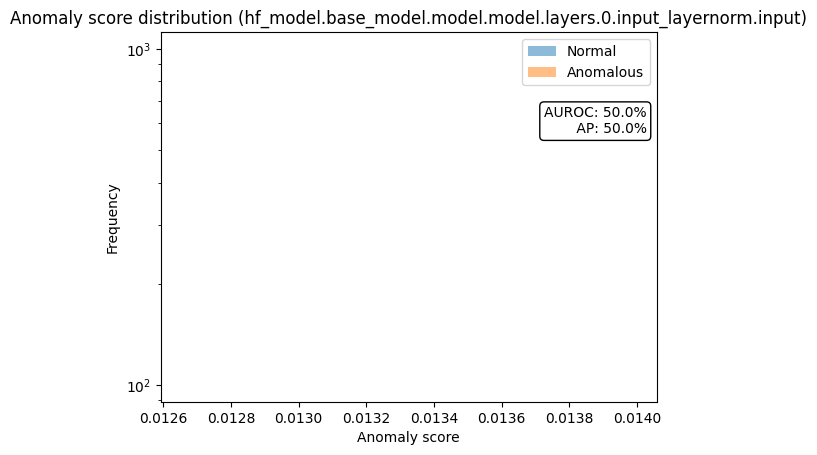

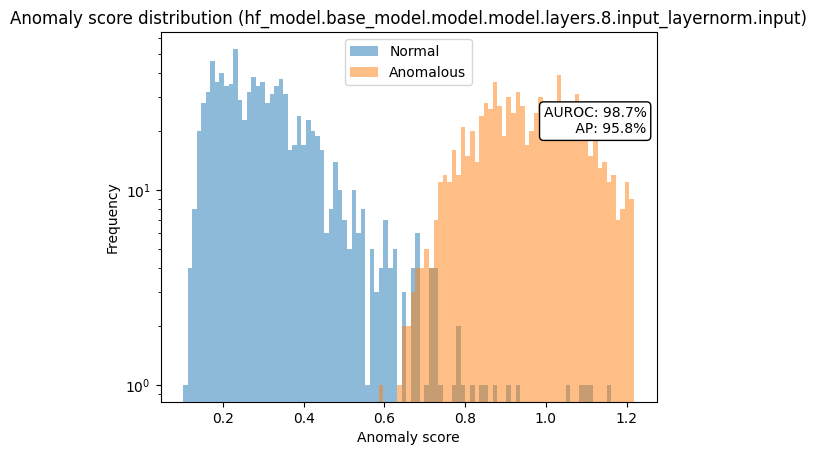

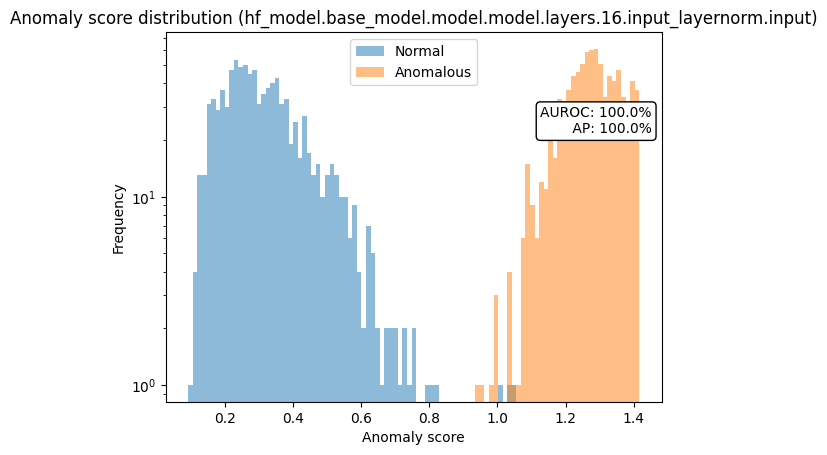

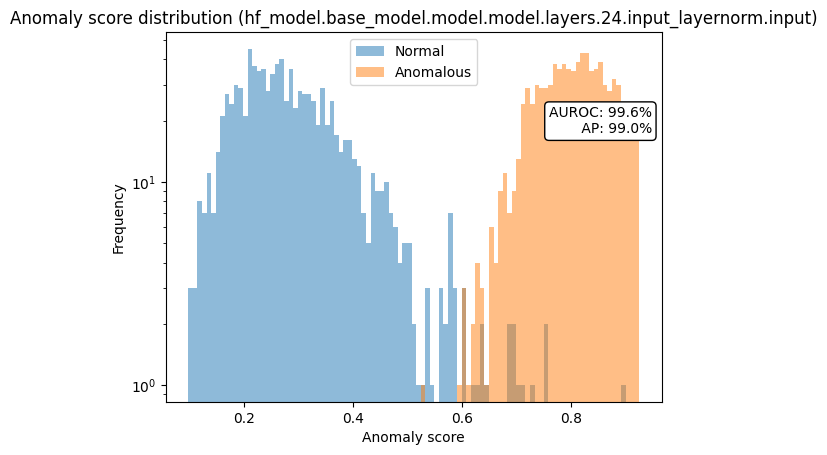

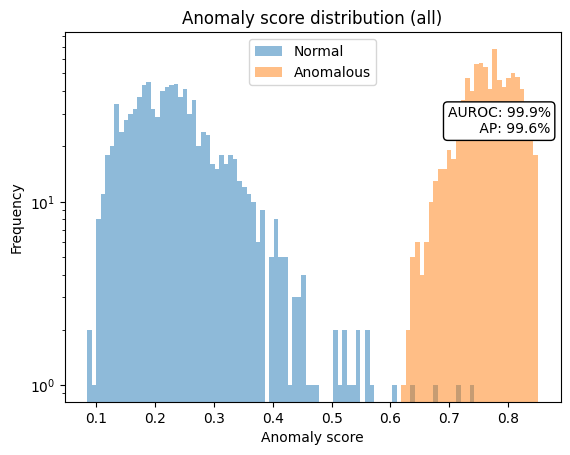

In [18]:
detector.eval(task, batch_size=16, layerwise=True, pbar=True)

In [23]:
detector.save_weights("llama3-backdoor-mahalanobis")

2024-10-07 20:35:39.406 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:433 - Saving detector to llama3-backdoor-mahalanobis


In [26]:
harmful_task = cup.tasks.Task.from_separate_data(
    model=cup_model,
    trusted_data=make_dataset(
        dataset["normal_harmful_train"].shuffle().select(range(1000))
    ),
    clean_test_data=make_dataset(
        dataset["normal_harmful_test"].shuffle().select(range(500))
    ),
    anomalous_test_data=make_dataset(
        dataset["backdoored_test"].shuffle().select(range(500))
    ),
)

2024-10-07 20:31:20.825 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:31:20.826 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:31:20.879 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.6417
2024-10-07 20:31:20.879 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.5591
2024-10-07 20:31:20.976 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.16.input_layernorm.input): 0.8147
2024-10-07 20:31:20.977 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_mode

(defaultdict(dict,
             {'hf_model.base_model.model.model.layers.0.input_layernorm.input': {'AUC_ROC': np.float64(0.5),
               'AP': np.float64(0.5)},
              'hf_model.base_model.model.model.layers.8.input_layernorm.input': {'AUC_ROC': np.float64(0.6417280000000001),
               'AP': np.float64(0.5591378628189949)},
              'hf_model.base_model.model.model.layers.16.input_layernorm.input': {'AUC_ROC': np.float64(0.8147359999999999),
               'AP': np.float64(0.7204802744803087)},
              'hf_model.base_model.model.model.layers.24.input_layernorm.input': {'AUC_ROC': np.float64(0.799892),
               'AP': np.float64(0.7950090810054828)},
              'all': {'AUC_ROC': np.float64(0.7955260000000001),
               'AP': np.float64(0.6956627240863522)}}),
 {'hf_model.base_model.model.model.layers.0.input_layernorm.input': <Figure size 640x480 with 1 Axes>,
  'hf_model.base_model.model.model.layers.8.input_layernorm.input': <Figure size 64

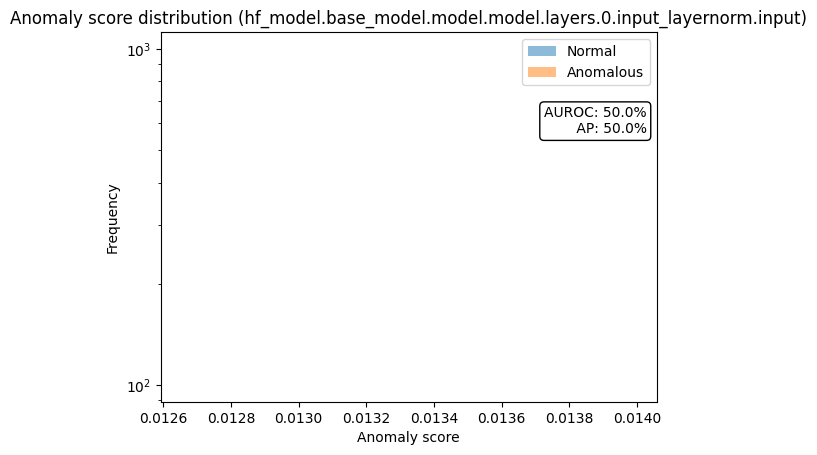

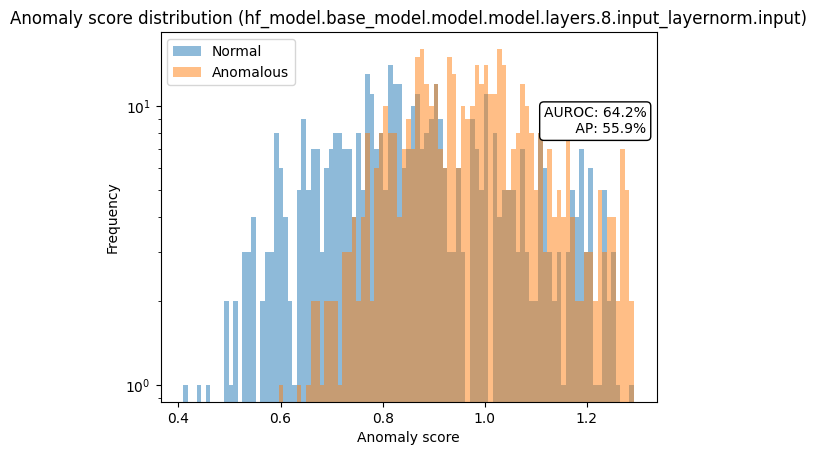

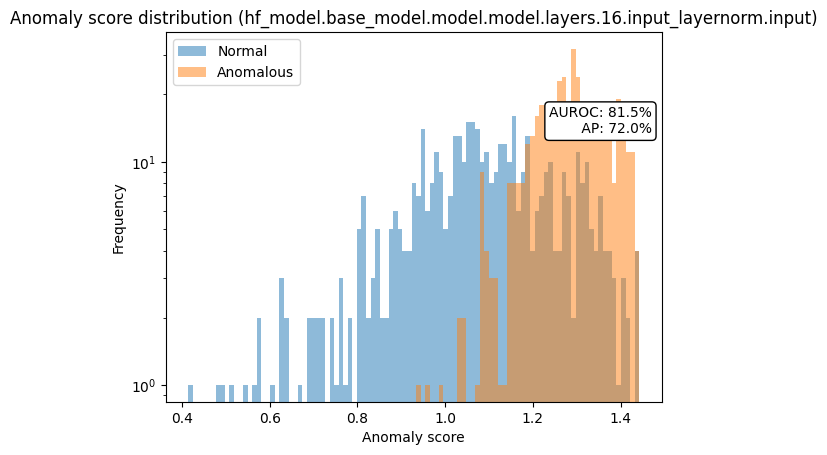

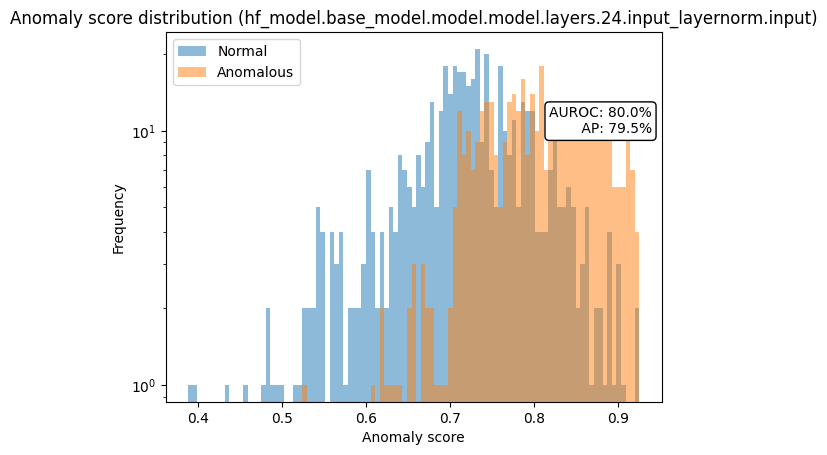

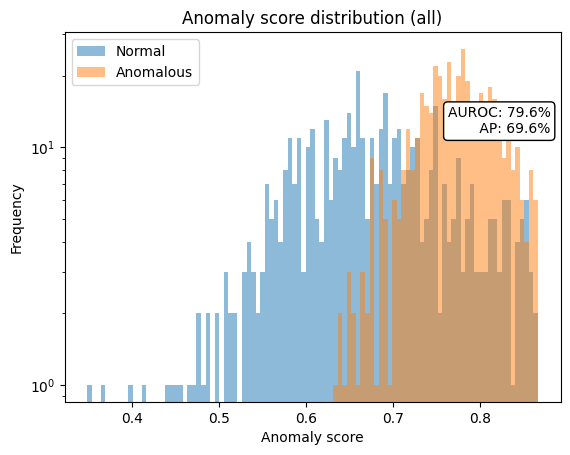

In [21]:
detector.eval(harmful_task, batch_size=16, layerwise=True, pbar=True)

In [27]:
harmful_detector = cup.detectors.MahalanobisDetector(
    activation_names=[
        f"hf_model.base_model.model.model.layers.{i}.input_layernorm.input"
        for i in range(0, 32, 8)
    ],
    individual_processing_fn=cup_model.make_last_token_hook(),
)
harmful_detector.train(harmful_task, batch_size=16)

2024-10-07 20:37:02.181 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:51 - Collecting statistics on trusted data
2024-10-07 20:37:02.631 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:86 - Activation sizes: 
hf_model.base_model.model.model.layers.0.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.8.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.16.input_layernorm.input: torch.Size([4096])
hf_model.base_model.model.model.layers.24.input_layernorm.input: torch.Size([4096])
100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


In [30]:
harmful_detector.save_weights("llama3-backdoor-mahalanobis-harmful-train")

2024-10-07 20:42:47.461 | INFO     | cupbearer.detectors.anomaly_detector:save_weights:433 - Saving detector to llama3-backdoor-mahalanobis-harmful-train


2024-10-07 20:38:07.332 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:38:07.334 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.0.input_layernorm.input): 0.5000
2024-10-07 20:38:07.393 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.9794
2024-10-07 20:38:07.394 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_model.model.model.layers.8.input_layernorm.input): 0.9438
2024-10-07 20:38:07.499 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:344 - AUC_ROC (hf_model.base_model.model.model.layers.16.input_layernorm.input): 0.9986
2024-10-07 20:38:07.500 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AP (hf_model.base_mode

(defaultdict(dict,
             {'hf_model.base_model.model.model.layers.0.input_layernorm.input': {'AUC_ROC': np.float64(0.5),
               'AP': np.float64(0.5)},
              'hf_model.base_model.model.model.layers.8.input_layernorm.input': {'AUC_ROC': np.float64(0.97936),
               'AP': np.float64(0.9437975782636607)},
              'hf_model.base_model.model.model.layers.16.input_layernorm.input': {'AUC_ROC': np.float64(0.998628),
               'AP': np.float64(0.9984203887610056)},
              'hf_model.base_model.model.model.layers.24.input_layernorm.input': {'AUC_ROC': np.float64(0.9937),
               'AP': np.float64(0.9817272853102033)},
              'all': {'AUC_ROC': np.float64(0.995644),
               'AP': np.float64(0.9855704984787897)}}),
 {'hf_model.base_model.model.model.layers.0.input_layernorm.input': <Figure size 640x480 with 1 Axes>,
  'hf_model.base_model.model.model.layers.8.input_layernorm.input': <Figure size 640x480 with 1 Axes>,
  'hf_model.b

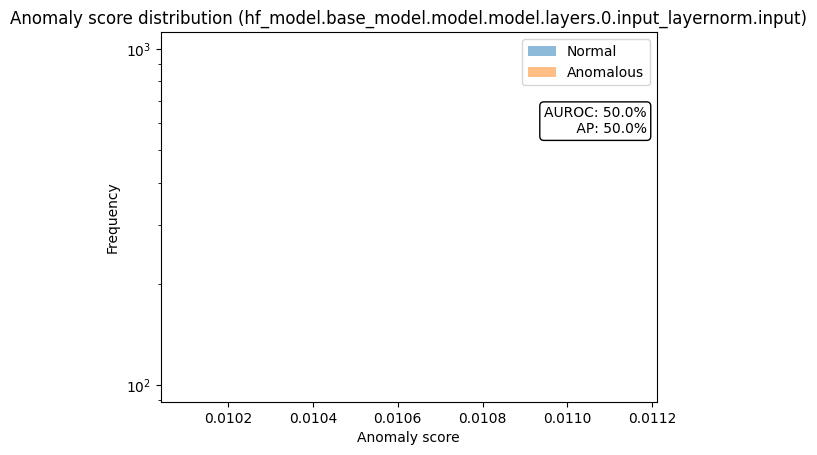

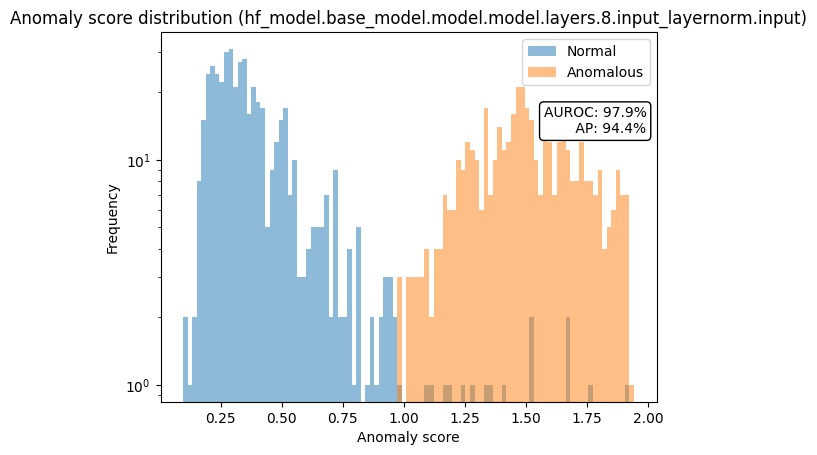

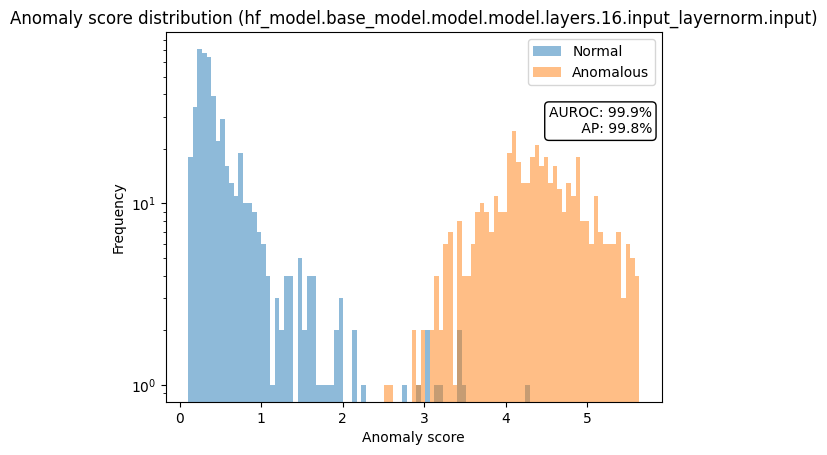

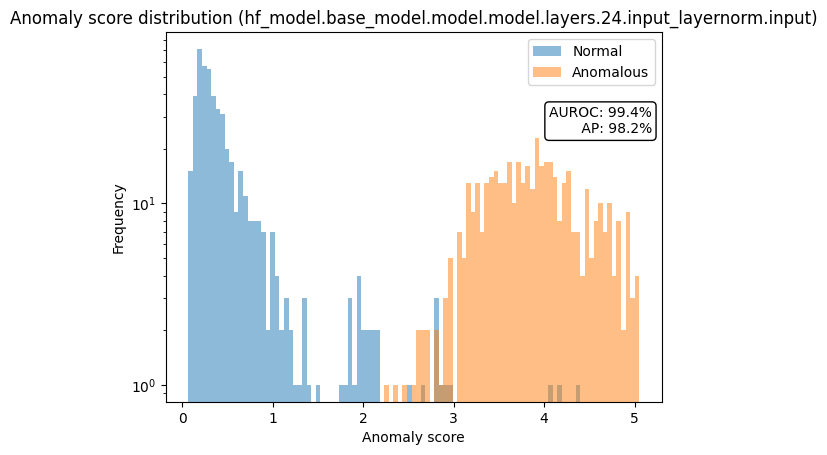

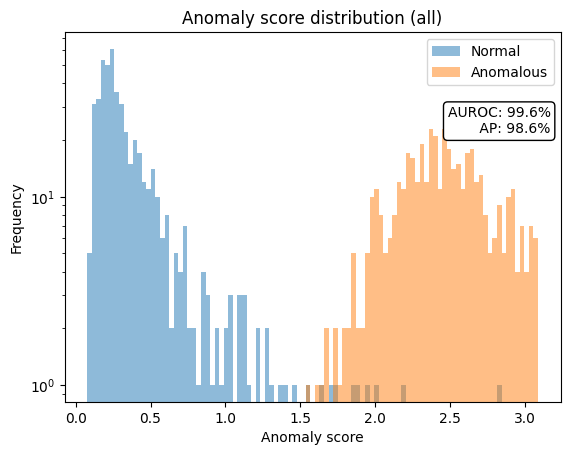

In [28]:
harmful_detector.eval(harmful_task, batch_size=16, layerwise=True, pbar=True)